# Dataset Token-Length Analysis
## Datensatz: Zorryy/news_articles_2025_elections_germany

Analyse der Token-Länge (BERT Tokenizer) aller Artikel im Datensatz.

1. Histogram: Token-Länge aller Artikel (raw + labeled)
2. Histogram: Token-Länge nur gelabelter Artikel (train + test)
3. Vergleichsplot: Raw vs. Labeled Verteilung
4. Tabelle: Anzahl Artikel pro Bin (gesamter Datensatz)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datasets import load_dataset
from transformers import AutoTokenizer
from IPython.display import display

In [2]:
DATASET_ID = "Zorryy/news_articles_2025_elections_germany"
ds = load_dataset(DATASET_ID)

print("Splits:", list(ds.keys()))
for split_name, split_ds in ds.items():
    print(f"  {split_name}: {len(split_ds)} Artikel")

Splits: ['raw', 'train', 'test']
  raw: 258876 Artikel
  train: 1304 Artikel
  test: 617 Artikel


In [3]:
# DataFrames erstellen
raw_df = ds["raw"].to_pandas() if "raw" in ds else pd.DataFrame()
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

labeled_df = pd.concat([train_df, test_df], ignore_index=True)
all_df = pd.concat([raw_df, labeled_df], ignore_index=True) if len(raw_df) > 0 else labeled_df.copy()

print(f"Raw:      {len(raw_df):>7} Artikel")
print(f"Labeled:  {len(labeled_df):>7} Artikel (train={len(train_df)}, test={len(test_df)})")
print(f"Gesamt:   {len(all_df):>7} Artikel")

Raw:       258876 Artikel
Labeled:     1921 Artikel (train=1304, test=617)
Gesamt:    260797 Artikel


In [4]:
# BERT Tokenizer laden und Token-Längen berechnen
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

def token_lengths(df, text_col="text"):
    """Berechnet Token-Längen für eine Spalte."""
    texts = df[text_col].fillna("").tolist()
    encoded = tokenizer(texts, truncation=False, add_special_tokens=False)
    return [len(ids) for ids in encoded["input_ids"]]

print("Tokenisiere gesamten Datensatz...")
all_df["token_len"] = token_lengths(all_df)

print("Tokenisiere gelabelte Artikel...")
labeled_df["token_len"] = token_lengths(labeled_df)

print(f"\nGesamter Datensatz  — min: {all_df['token_len'].min()}, max: {all_df['token_len'].max()}, median: {all_df['token_len'].median():.0f}, mean: {all_df['token_len'].mean():.0f}")
print(f"Gelabelte Artikel   — min: {labeled_df['token_len'].min()}, max: {labeled_df['token_len'].max()}, median: {labeled_df['token_len'].median():.0f}, mean: {labeled_df['token_len'].mean():.0f}")

Tokenisiere gesamten Datensatz...


Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors


Tokenisiere gelabelte Artikel...

Gesamter Datensatz  — min: 2, max: 74155, median: 392, mean: 492
Gelabelte Artikel   — min: 25, max: 13733, median: 667, mean: 889


In [5]:
# Gemeinsame Bins: 99. Perzentil als obere Grenze (Ausreißer separat)
NUM_BINS = 12
p99 = np.percentile(all_df["token_len"], 99)
bin_max = int(np.ceil(p99 / 100) * 100)  # auf volle Hunderter aufrunden
bins = np.linspace(0, bin_max, NUM_BINS + 1)

n_outliers_all = (all_df["token_len"] > bin_max).sum()
n_outliers_labeled = (labeled_df["token_len"] > bin_max).sum()

print(f"99. Perzentil: {p99:.0f} Tokens → Bin-Obergrenze: {bin_max}")
print(f"Ausreißer (>{bin_max} Tokens): {n_outliers_all} gesamt, {n_outliers_labeled} gelabelt")
print(f"\nBin-Grenzen ({NUM_BINS} Bins):")
for i in range(NUM_BINS):
    print(f"  Bin {i+1:>2}: {bins[i]:>6.0f} – {bins[i+1]:>6.0f}")

99. Perzentil: 2003 Tokens → Bin-Obergrenze: 2100
Ausreißer (>2100 Tokens): 2199 gesamt, 90 gelabelt

Bin-Grenzen (12 Bins):
  Bin  1:      0 –    175
  Bin  2:    175 –    350
  Bin  3:    350 –    525
  Bin  4:    525 –    700
  Bin  5:    700 –    875
  Bin  6:    875 –   1050
  Bin  7:   1050 –   1225
  Bin  8:   1225 –   1400
  Bin  9:   1400 –   1575
  Bin 10:   1575 –   1750
  Bin 11:   1750 –   1925
  Bin 12:   1925 –   2100


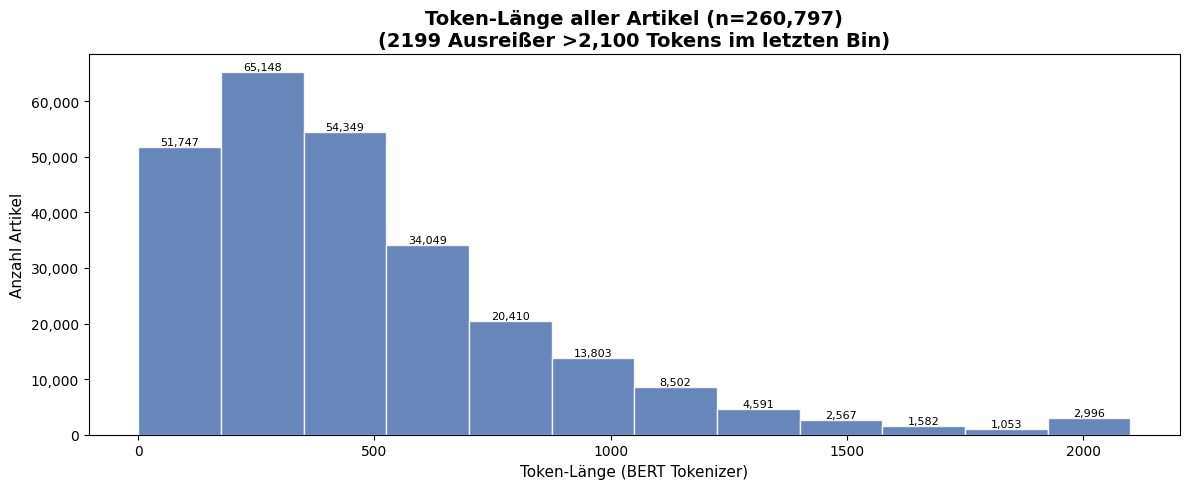

In [6]:
# --- Histogram 1: Gesamter Datensatz ---
clipped_all = all_df["token_len"].clip(upper=bin_max)

fig, ax = plt.subplots(figsize=(12, 5))
counts_all, _, patches = ax.hist(clipped_all, bins=bins, edgecolor="white", color="#4C72B0", alpha=0.85)

for count, patch in zip(counts_all, patches):
    if count > 0:
        ax.text(patch.get_x() + patch.get_width() / 2, count, f"{int(count):,}",
                ha="center", va="bottom", fontsize=8)

title = f"Token-Länge aller Artikel (n={len(all_df):,})"
if n_outliers_all > 0:
    title += f"\n({n_outliers_all} Ausreißer >{bin_max:,} Tokens im letzten Bin)"
ax.set_title(title, fontsize=14, fontweight="bold")
ax.set_xlabel("Token-Länge (BERT Tokenizer)", fontsize=11)
ax.set_ylabel("Anzahl Artikel", fontsize=11)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

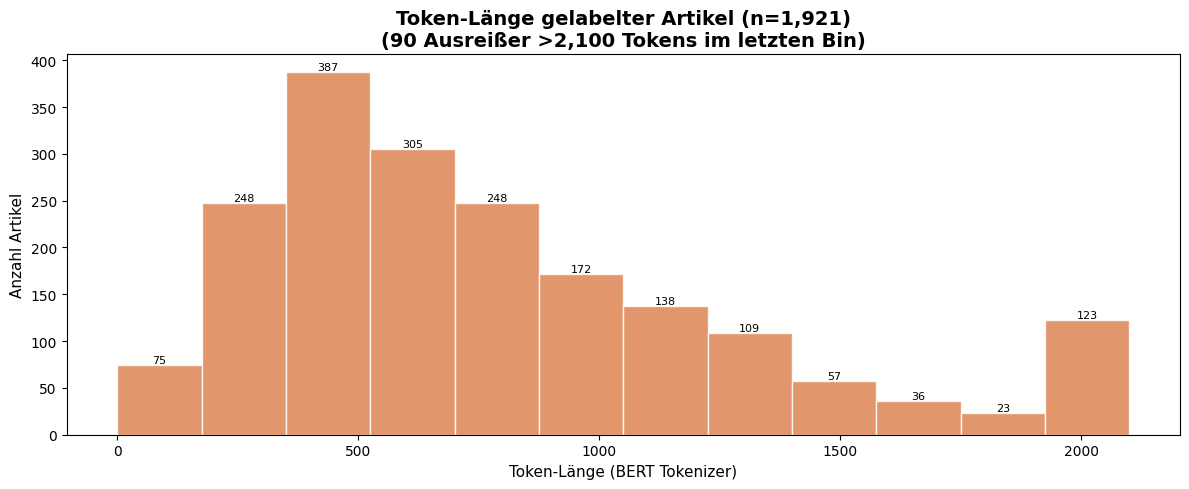

In [7]:
# --- Histogram 2: Nur gelabelte Artikel (train + test) ---
clipped_labeled = labeled_df["token_len"].clip(upper=bin_max)

fig, ax = plt.subplots(figsize=(12, 5))
counts_labeled, _, patches = ax.hist(clipped_labeled, bins=bins, edgecolor="white", color="#DD8452", alpha=0.85)

for count, patch in zip(counts_labeled, patches):
    if count > 0:
        ax.text(patch.get_x() + patch.get_width() / 2, count, f"{int(count):,}",
                ha="center", va="bottom", fontsize=8)

title = f"Token-Länge gelabelter Artikel (n={len(labeled_df):,})"
if n_outliers_labeled > 0:
    title += f"\n({n_outliers_labeled} Ausreißer >{bin_max:,} Tokens im letzten Bin)"
ax.set_title(title, fontsize=14, fontweight="bold")
ax.set_xlabel("Token-Länge (BERT Tokenizer)", fontsize=11)
ax.set_ylabel("Anzahl Artikel", fontsize=11)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

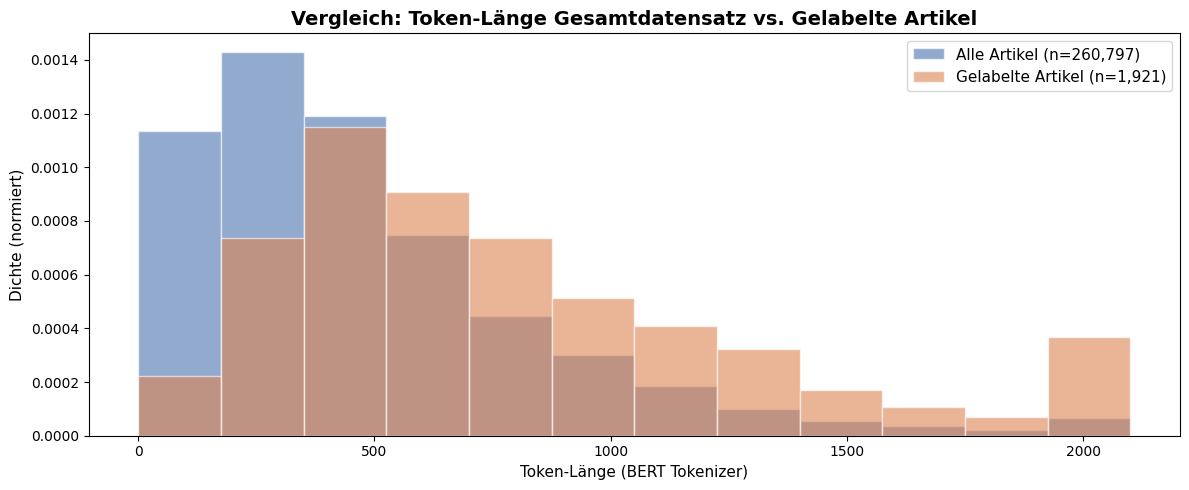

In [8]:
# --- Vergleichsplot: Gesamter Datensatz vs. Gelabelte Artikel (normiert) ---
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(clipped_all, bins=bins, density=True, edgecolor="white",
        color="#4C72B0", alpha=0.6, label=f"Alle Artikel (n={len(all_df):,})")
ax.hist(clipped_labeled, bins=bins, density=True, edgecolor="white",
        color="#DD8452", alpha=0.6, label=f"Gelabelte Artikel (n={len(labeled_df):,})")

ax.set_title("Vergleich: Token-Länge Gesamtdatensatz vs. Gelabelte Artikel", fontsize=14, fontweight="bold")
ax.set_xlabel("Token-Länge (BERT Tokenizer)", fontsize=11)
ax.set_ylabel("Dichte (normiert)", fontsize=11)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [9]:
# --- Tabelle: Anzahl pro Bin (gesamter Datensatz) ---
bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}" for i in range(NUM_BINS)]
table_df = pd.DataFrame({
    "Bin": bin_labels,
    "Anzahl Artikel": [int(c) for c in counts_all],
    "Anteil (%)": [c / len(all_df) * 100 for c in counts_all],
})
table_df["Anteil (%)"] = table_df["Anteil (%)"].map("{:.1f}".format)
table_df.index = range(1, NUM_BINS + 1)
table_df.index.name = "#"

print(f"\nToken-Länge Verteilung — Gesamter Datensatz (n={len(all_df):,})")
print("=" * 55)
display(table_df)


Token-Länge Verteilung — Gesamter Datensatz (n=260,797)


,Bin,Anzahl Artikel,Anteil (%)
#,,,
1,0 – 175,51747,19.8
2,175 – 350,65148,25.0
3,350 – 525,54349,20.8
4,525 – 700,34049,13.1
5,700 – 875,20410,7.8
6,"875 – 1,050",13803,5.3
7,"1,050 – 1,225",8502,3.3
8,"1,225 – 1,400",4591,1.8
9,"1,400 – 1,575",2567,1.0
